In [2]:
import pandas as pd


customers_path = "C:\\Users\\DELL\\Downloads\\Customers.csv" 
products_path = "C:\\Users\\DELL\\Downloads\\Products.csv"
transactions_path =  "C:\\Users\\DELL\\Downloads\\Transactions.csv"

customers_df = pd.read_csv(customers_path)
products_df = pd.read_csv(products_path)
transactions_df = pd.read_csv(transactions_path)

customers_head = customers_df.head()
products_head = products_df.head()
transactions_head = transactions_df.head()

customers_head, products_head, transactions_head


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55    

In [3]:

merged_df = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")

total_spending = merged_df.groupby("CustomerID")["TotalValue"].sum().rename("TotalSpending")


transaction_count = merged_df.groupby("CustomerID")["TransactionID"].count().rename("TransactionCount")


avg_transaction_value = total_spending / transaction_count
avg_transaction_value.rename("AvgTransactionValue", inplace=True)


customer_features = pd.DataFrame({
    "TotalSpending": total_spending,
    "TransactionCount": transaction_count,
    "AvgTransactionValue": avg_transaction_value
}).reset_index()

customer_features = pd.merge(customer_features, customers_df[["CustomerID", "Region", "SignupDate"]], on="CustomerID")

customer_features.head()


,CustomerID,TotalSpending,TransactionCount,AvgTransactionValue,Region,SignupDate
0,C0001,3354.52,5,670.904,South America,2022-07-10
1,C0002,1862.74,4,465.685,Asia,2022-02-13
2,C0003,2725.38,4,681.345,South America,2024-03-07
3,C0004,5354.88,8,669.360,South America,2022-10-09
4,C0005,2034.24,3,678.080,Asia,2022-08-15


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score


numerical_features = customer_features[["TotalSpending", "TransactionCount", "AvgTransactionValue"]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)


results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    results.append((n_clusters, db_index))

results_df = pd.DataFrame(results, columns=["Number of Clusters", "DB Index"])
optimal_clusters = results_df.loc[results_df["DB Index"].idxmin()]

results_df, optimal_clusters


(   Number of Clusters  DB Index
 0                   2  1.007225
 1                   3  0.957821
 2                   4  1.060424
 3                   5  0.852481
 4                   6  0.869377
 5                   7  0.855311
 6                   8  0.912532
 7                   9  0.884755
 8                  10  0.863046,
 Number of Clusters    5.000000
 DB Index              0.852481
 Name: 3, dtype: float64)

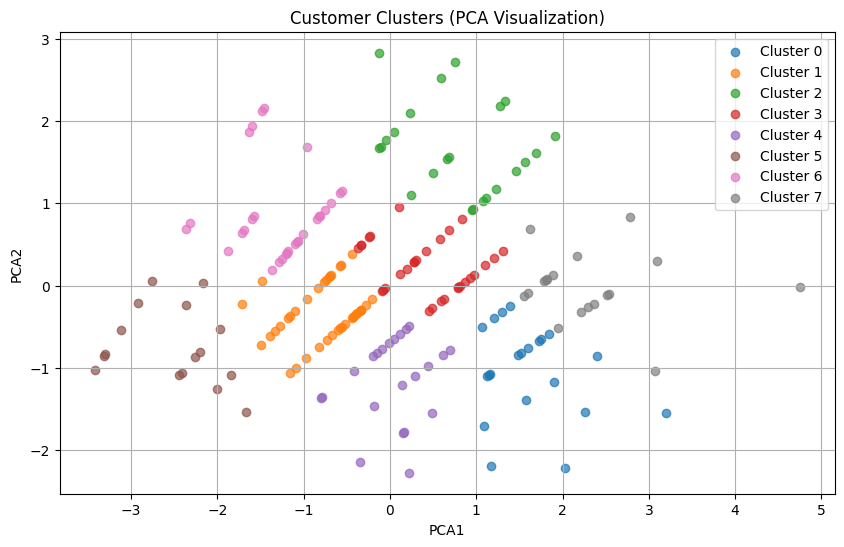

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


kmeans_optimal = KMeans(n_clusters=8, random_state=42)
customer_features["Cluster"] = kmeans_optimal.fit_predict(scaled_features)


pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
customer_features["PCA1"] = pca_result[:, 0]
customer_features["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
for cluster in range(8):
    cluster_data = customer_features[customer_features["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster}", alpha=0.7)
plt.title("Customer Clusters (PCA Visualization)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.grid()
plt.show()
